In [1]:
import os
import os
os.environ["NUMPY_EXPERIMENTAL_DTYPE_API"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as constants
import sys
import xarray as xr
import pdb
import copy as cp


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from metpy.plots import SkewT

In [3]:
# Pour fixer la taille de la police partout
import matplotlib as matplotlib
#matplotlib.rcParams['font.family'] = "normal"
#matplotlib.rcParams['size'] = 15
font = {'family' : 'Avenir',
        'size'   : 15}
matplotlib.rc('font', **font)

In [4]:
outpath='./figures/' # repertoire pour les figures, il faut le creer dans votre repertoire

In [5]:
units=r'W m$^{-2}$' # Unités puissance
emiss_s=1. # Emissivité surface
emiss_a=0.77 #Emissivité atmosphere
alb=.25 # Albedo surface
S0=1376. # in W/m2
sigma=5.6767E-08 #Stefan-Boltzmann
levels=np.arange(200,330,20)
levels=[298]
Tlims=[180,310]
Nz=30 # nombre de niveaux verticaux

In [6]:
# Load the reference vertical temperature profile from the NCEP reanalysis
ncep_lev=np.load('npy/ncep_lev.npy')
ncep_T=np.load('npy/ncep_T.npy')+273.15


In [7]:
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)

In [8]:
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)

In [9]:
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)

In [10]:
# Creation d'un modele couplé avec rayonnement, convection et vapeur d'eau
rcm = climlab.couple([rad,h2o], name='Radiative-Equilibrium Model')
rcm2 = climlab.process_like(rcm) # creation d'un clone du modele rcm

In [89]:
#Fonction prise directement de la documentation climlab
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
#     skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend(fontsize=12)
    skew.ax.set_xlabel('Température [°C]', fontsize=14)
    skew.ax.set_ylabel('Pression [hPa]', fontsize=14)
    return skew
#  and a function to add extra profiles to this chart
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    try:
        skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=2, color=line.get_color())
    except:
        pass
    skew.ax.legend(fontsize=12)


In [40]:
# ncep doit devenir une instance de classe 
# pour se faire appeler correctement par "add_profile" de la documentation climlab
class NCEP:
    
    global ncep_T, ncep_lev
    
    def __init__(self,ncep_T,ncep_lev):
        self.lev = ncep_lev
        self.Tatm = ncep_T
        self.name = "réanalyse NCEP"


In [57]:
#Atmosphere Reset
def atmosphere_reset():
    alb=.2 # Albedo surface utilisé dans l'analyse des \Gamma
    global state,h2o,rad,rcm,rcm2
    #  State variables (Air and surface temperature)
    state = climlab.column_state(num_lev=30)

    #  Fixed relative humidity
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)

    #  Couple water vapor to radiation
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
    conv = climlab.convection.ConvectiveAdjustment(name='Convection', state=state, adj_lapse_rate=5.5)
    rcm = climlab.couple([rad,conv,h2o], name='Radiative-Convective Model')

In [41]:
ncep=NCEP(ncep_T,ncep_lev)

In [33]:
ncep.Tatm

array([288.32907, 284.357  , 280.9883 , 273.36993, 266.70166, 258.26114,
       247.57953, 233.7803 , 226.35208, 219.49774, 212.58644, 206.14395,
       207.61707, 211.66336, 217.2964 , 221.55605, 229.93001],
      dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


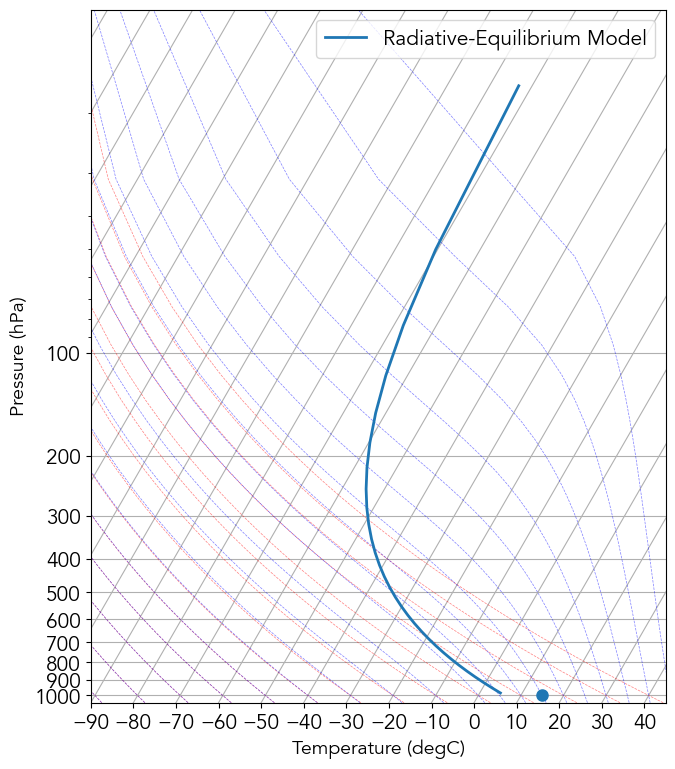

In [16]:
skew=make_skewT()
add_profile(skew,rcm)

In [19]:
conv = climlab.convection.ConvectiveAdjustment(name='Convection', state=state, adj_lapse_rate=5.5)
rcm = climlab.couple([rad,conv,h2o], name='Radiative-Convective Model')
rcm.integrate_years(2)
rcm.Tatm


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


Field([237.28083526, 216.92091236, 212.80535908, 212.31368811,
       212.85179805, 214.66615051, 219.92461269, 225.05262761,
       229.63577841, 233.78683848, 237.58616061, 241.09313074,
       244.35294801, 247.40085433, 250.26488841, 252.96774375,
       255.52806033, 257.96134604, 260.28064884, 262.49705655,
       264.62007518, 266.65791951, 268.61773948, 270.50579876,
       272.32761706, 274.08808488, 275.79155674, 277.4419277 ,
       279.04269655, 280.59701845])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


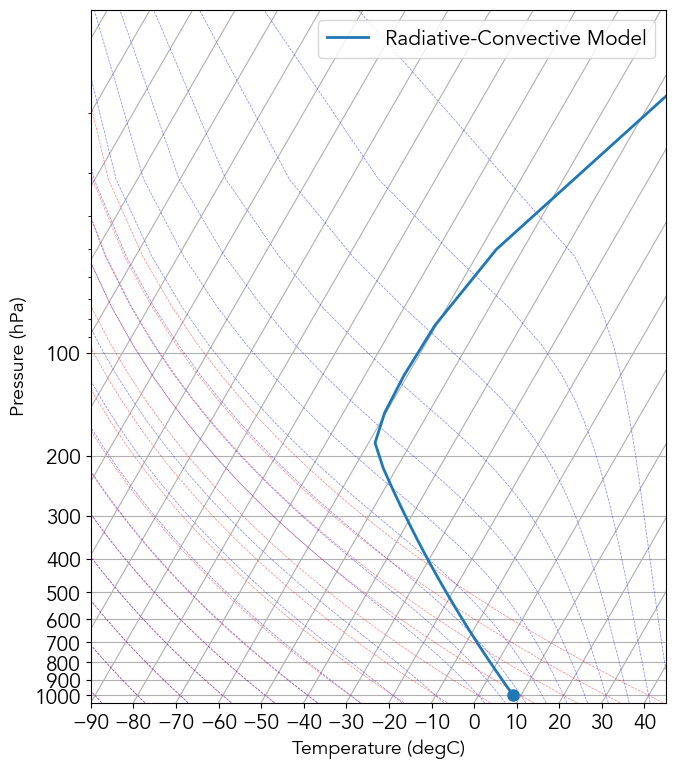

In [20]:
skew=make_skewT()
add_profile(skew,rcm)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Integrating for 10957 steps, 10957.266000000001 days, or 30 years.
Total elapsed time is 29.999271716137947 years.
Integrating for 10957 steps, 10957.266000000001 days, or 30 years.
Total elapsed time is 29.999271716137947 years.
Integrating for 10957 steps, 10957.266000000001 days, or 30 years.
Total elapsed time is 29.999271716137947 years.


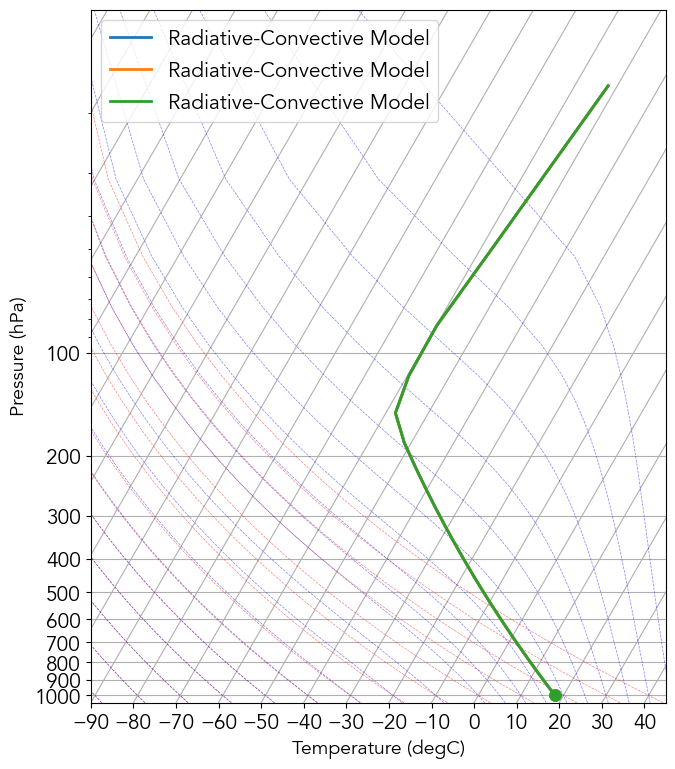

In [51]:
skew=make_skewT()
for years in (1,2,3):
    conv = climlab.convection.ConvectiveAdjustment(name='Convection', state=state, adj_lapse_rate=5.5)
    rcm = climlab.couple([rad,conv,h2o], name='Radiative-Convective Model')
    rcm.integrate_years(30) 
    add_profile(skew,rcm)
#aucune différence selon le temps d'intégration, modèle à l'équilibre après 2 ans

In [124]:
def period_label(p):
    global rcm
    co2=round(rcm.absorber_vmr['CO2']*(1E6),2)
    ch4=round(rcm.absorber_vmr['CH4']*(1E6),2)
    return f"rcm,{[p*30 if p>0 else ''][0]} {['ans' if p>0 else 'actuel'][0]}\n"+r"$[CO_2]=$"+f"{co2} ppm"+"\n"+r"$[CH_4]=$"+f"{ch4} ppm"


Integrating for 730 steps, 730.4844 days, or 2 years.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total elapsed time is 1.9986737567564754 years.
0.000348
0.000435
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
0.000435
0.00054375
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 5.996021270269426 years.
0.00054375
0.0006796875
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 7.994695027025902 years.
0.0006796875
0.0008496093749999999
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 9.993368783782378 years.
dTs =  3.16
dTatm0 =  -6.76


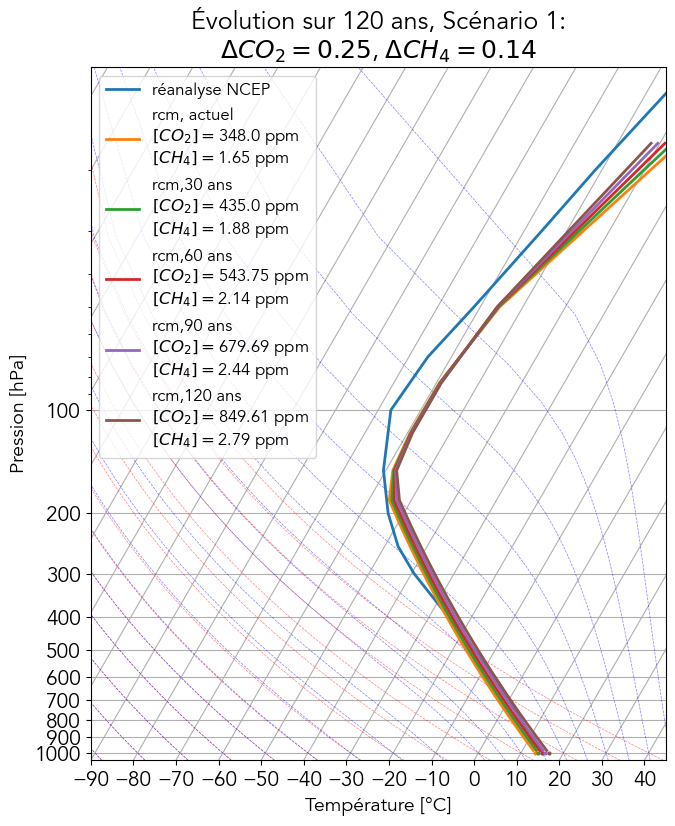

In [125]:
# CAS 1 : le CO2 augmente de 25% par 30 ans, le CH4 augmente de 14% par période de 30 ans
D_CO2=1.25
D_CH4=1.14
#Normalisation de l'Atmosphère (pour ne pas être influencé par les autres cellules)
atmosphere_reset()
rcm.integrate_years(2)

# suivi : Températures de surface
Ts_i = float(rcm.Ts[0])

#suivi : Température du dernier niveau atmosphérique simulé
Tatm0_i = float(rcm.Tatm[0])

#SkewT
skew=make_skewT()

#Profil de la réanalyse Ncep ajouté au SkewT
add_profile(skew,ncep)

# Périodes avec changement de températures du au CO2
for période in (0,1,2,3,4):
    if période == 0:
        rcm.name = period_label(période)
        add_profile(skew,rcm)
    else:
        print(rcm.absorber_vmr['CO2'])
        rcm.absorber_vmr['CO2']=(D_CO2)*rcm.absorber_vmr['CO2']
        print(rcm.absorber_vmr['CO2'])
        rcm.absorber_vmr['CH4']=(D_CH4)*rcm.absorber_vmr['CH4']
        rcm.integrate_years(2)
        rcm.name = period_label(période)
        add_profile(skew,rcm)
plt.title(f"Évolution sur 120 ans, Scénario 1:\n"+
          r"$\Delta$$CO_2=0.25$, $\Delta$$CH_4=0.14$")
# plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
plt.savefig("./figures/skew1.png", dpi=300)
#suivi : Température de surface
Ts_f=float(rcm.Ts[0])
dTs = Ts_f-Ts_i
print("dTs = ",round(dTs,2))

#suivi : Température du dernier niveau atmosphérique simulé
Tatm0_f = float(rcm.Tatm[0])
DTatm0 = Tatm0_f-Tatm0_i
print("dTatm0 = ",round(DTatm0,2))

Integrating for 730 steps, 730.4844 days, or 2 years.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total elapsed time is 1.9986737567564754 years.
286.4997008033899
0.000348
0.00052548
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
[287.89793338]
0.00052548
0.0007987296000000001
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 5.996021270269426 years.
[289.43357899]
0.0007987296000000001
0.0012220562880000002
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 7.994695027025902 years.
[291.16013989]
0.0012220562880000002
0.0018819666835200003
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 9.993368783782378 years.
[293.02674931]
dTs =  6.53
dTatm0 =  -11.63


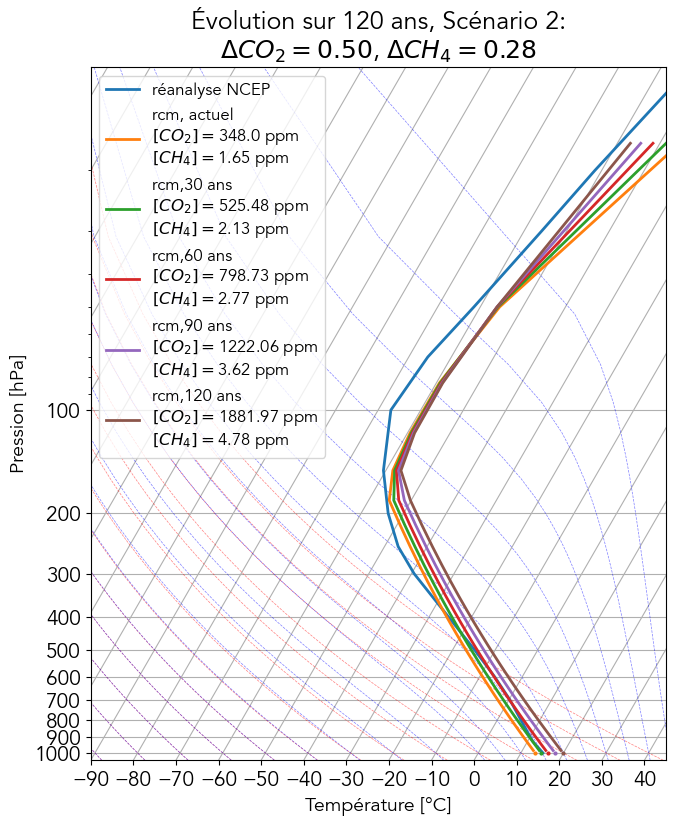

In [127]:
# CAS 2 : le CO2 augmente de 50% par 30 ans, le CH4 augmente de 28% par période de 30 ans
D_CO2=1.50
D_CH4=1.28
#Normalisation de l'Atmosphère (pour ne pas être influencé par les autres cellules)
atmosphere_reset()
rcm.integrate_years(2)

# suivi : Températures de surface
Ts_i = float(rcm.Ts[0])

#suivi : Température du dernier niveau atmosphérique simulé
Tatm0_i = float(rcm.Tatm[0])

print(Ts_i)
#SkewT
skew=make_skewT()

#Profil de la réanalyse Ncep ajouté au SkewT
add_profile(skew,ncep)

# Périodes avec changement de températures du au CO2
for période in (0,1,2,3,4):
    if période == 0:
        rcm.name = period_label(période)
        add_profile(skew,rcm)

    else:
        print(rcm.absorber_vmr['CO2'])
        rcm.absorber_vmr['CO2']=(D_CO2+(période/100))*rcm.absorber_vmr['CO2']
        print(rcm.absorber_vmr['CO2'])
        rcm.absorber_vmr['CH4']=(D_CH4+(période/100))*rcm.absorber_vmr['CH4']
        rcm.integrate_years(2)
        rcm.name = period_label(période)
        add_profile(skew,rcm)
        print(rcm.Ts)

plt.title(f"Évolution sur 120 ans, Scénario 2:\n"+
          r"$\Delta$$CO_2=0.50$, $\Delta$$CH_4=0.28$")
# plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
plt.savefig("./figures/skew2.png", dpi=300)

#suivi : Température de surface
Ts_f=float(rcm.Ts[0])
dTs = Ts_f-Ts_i
print("dTs = ",round(dTs,2))

#suivi : Température du dernier niveau atmosphérique simulé
Tatm0_f = float(rcm.Tatm[0])
DTatm0 = Tatm0_f-Tatm0_i
print("dTatm0 = ",round(DTatm0,2))